In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

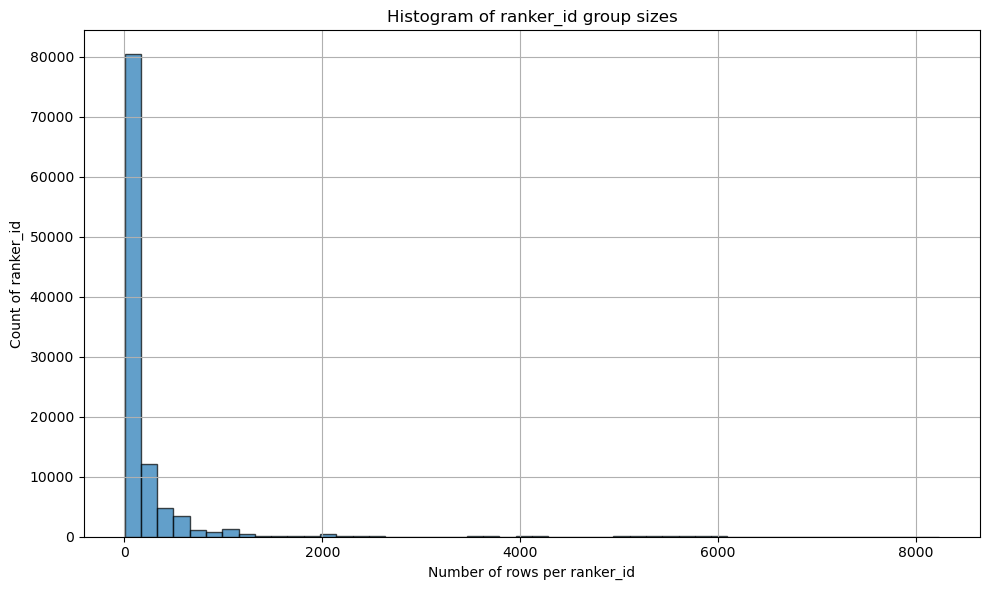

In [2]:
import polars as pl
import matplotlib.pyplot as plt

# Load data
train = pl.read_parquet('data/train_filled.parquet')

# 計算每個 ranker_id 出現次數
ranker_counts = (
    train
    .group_by("ranker_id")
    .agg(pl.len().alias("n_rows"))
    .sort("n_rows")
)

# 轉成 pandas
ranker_counts_pd = ranker_counts.to_pandas()

# 畫 histogram
plt.figure(figsize=(10,6))
plt.hist(ranker_counts_pd["n_rows"], bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Number of rows per ranker_id")
plt.ylabel("Count of ranker_id")
plt.title("Histogram of ranker_id group sizes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
ranker_counts_filtered = ranker_counts.filter(pl.col("n_rows") >= 3)
summary_filtered = ranker_counts_filtered.select([
    pl.col("n_rows").min().alias("min"),
    pl.col("n_rows").max().alias("max"),
    pl.col("n_rows").mean().alias("mean"),
    pl.col("n_rows").median().alias("median"),
    pl.col("n_rows").quantile(0.25, "nearest").alias("25%"),
    pl.col("n_rows").quantile(0.75, "nearest").alias("75%"),
    pl.col("n_rows").std().alias("std"),
])

print(summary_filtered)


shape: (1, 7)
┌─────┬──────┬────────────┬────────┬──────┬───────┬────────────┐
│ min ┆ max  ┆ mean       ┆ median ┆ 25%  ┆ 75%   ┆ std        │
│ --- ┆ ---  ┆ ---        ┆ ---    ┆ ---  ┆ ---   ┆ ---        │
│ u32 ┆ u32  ┆ f64        ┆ f64    ┆ f64  ┆ f64   ┆ f64        │
╞═════╪══════╪════════════╪════════╪══════╪═══════╪════════════╡
│ 3   ┆ 8236 ┆ 177.851194 ┆ 53.0   ┆ 21.0 ┆ 162.0 ┆ 452.477068 │
└─────┴──────┴────────────┴────────┴──────┴───────┴────────────┘


In [1]:
import os
import pandas as pd

def load_label_features(
    model_dir: str,
    split_labels: list,
    top_n: int = None
):
    """
    從模型資料夾讀取每個分群的特徵重要性檔案，回傳每個label的features list。
    
    參數:
    - model_dir: 模型資料夾
    - split_labels: 分群名稱list
    - top_n: 如果指定，只取前N個特徵；否則用第一個min_rank=9999為止

    回傳:
    - dict(label -> features list)
    """
    label_features = {}

    for label in split_labels:
        model_importance_dir = os.path.join(model_dir, "model_importance")
        csv_path = os.path.join(model_importance_dir, f"feature_importance_{label}_all_features.csv")

        df = pd.read_csv(csv_path)

        if top_n is not None:
            # 直接取前top_n
            feats = df.iloc[:top_n]["feature"].tolist()
            print(f"\n✅ {label}: 取前 {top_n} 個特徵")
        else:
            idx_first_unused = df[df["min_rank"] == 9999].index.min()
            feats = df["feature"].tolist()
            exclude_cols = {"n_rows", "group_category"}
            feats = [f for f in feats if f not in exclude_cols]

            print(f"\n✅ {label}: 第 {idx_first_unused} 名後都是完全未使用的特徵")
            print("✅ 第一個未使用特徵：")
            print(df.iloc[idx_first_unused])

        label_features[label] = feats

    # 印出所有分群features數量
    for label in split_labels:
        print(f"{label}: {len(label_features[label])} features")

    return label_features


In [2]:

model_dir = "model_output/all_features_xgb"

# 先把每個分群都讀一遍feature importance
split_labels = ["small", "medium", "large", 'xlarge']

label_features = load_label_features(
    model_dir=model_dir,
    split_labels=split_labels)



✅ small: 第 155 名後都是完全未使用的特徵
✅ 第一個未使用特徵：
feature            legs0_segments2_departureFrom_airport_iata
weight                                                    NaN
weight_rank_pos                                        9999.0
gain                                                      NaN
gain_rank_pos                                          9999.0
cover                                                     NaN
cover_rank_pos                                         9999.0
min_rank                                               9999.0
Name: 155, dtype: object

✅ medium: 第 165 名後都是完全未使用的特徵
✅ 第一個未使用特徵：
feature            legs0_segments3_marketingCarrier_code_in_ff
weight                                                     NaN
weight_rank_pos                                         9999.0
gain                                                       NaN
gain_rank_pos                                           9999.0
cover                                                      NaN
cover_rank_pos    

In [1]:
import numpy as np
import polars as pl

# 讀取
train_filled = pl.read_parquet("data/train_filled.parquet")

# 排除欄
needed_cols = [
     'ranker_id', 'selected'
]
remove = ['profileId', 'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt', "n_rows", "__index_level_0__","Id'"]

exclude_cols = needed_cols + remove

feature_cols = [c for c in train_filled.columns if c not in exclude_cols]

# 轉 float32
float64_cols = [c for c in feature_cols if train_filled[c].dtype == pl.Float64]
train_filled = train_filled.with_columns(
    [pl.col(c).cast(pl.Float32) for c in float64_cols]
)

all_features = feature_cols+needed_cols
train_filled = train_filled.select(all_features)

In [2]:
# 找字串欄
str_cols = [c for c in train_filled.columns if train_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in train_filled.columns if train_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in train_filled.columns if train_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 2 個字串欄位
✅ 共找到 227 個數值欄位
✅ 共找到 0 個布林欄位


In [ ]:
import polars as pl
import os
import gc

def split_data_by_group_size(
    df: pl.DataFrame,
    bins: list,
    labels: list,
    output_dir: str,
    label_features: dict = None,
    unused_label_features: dict = None
):
    """
    分群 + 分批寫檔 + 釋放記憶體。

    df: polars.DataFrame
    bins: 分群邊界
    labels: 分群名稱
    output_dir: 每個群的 parquet 儲存目錄
    label_features: dict(label -> feature list)
    unused_label_features: dict(label -> feature list)，要排除的欄位
    """
    os.makedirs(output_dir, exist_ok=True)

    df = df.with_row_count("global_row_nr")

    group_counts = (
        df.group_by("ranker_id")
          .agg(pl.count().alias("n_rows"))
          .filter(pl.col("n_rows") >= bins[0])
    )

    bins_fixed = bins.copy()
    if bins_fixed[-1] is None:
        max_value = group_counts["n_rows"].max()
        bins_fixed[-1] = int(max_value) + 1

    if len(labels) != len(bins_fixed) - 1:
        raise ValueError(f"bins={bins_fixed} 有 {len(bins_fixed)-1}個區間，但labels數={len(labels)}")

    cond = (
        pl.when((pl.col("n_rows") >= bins_fixed[0]) & (pl.col("n_rows") < bins_fixed[1]))
        .then(pl.lit(labels[0]))
    )
    for i in range(1, len(labels)):
        cond = cond.when(
            (pl.col("n_rows") >= bins_fixed[i]) & (pl.col("n_rows") < bins_fixed[i+1])
        ).then(pl.lit(labels[i]))
    cond = cond.otherwise(pl.lit("unknown"))

    group_counts = group_counts.with_columns([
        cond.alias("group_category")
    ])

    df = df.join(group_counts, on="ranker_id", how="left")

    written_files = []
    effective_label_features = {}

    for lbl in labels:
        subset = df.filter(pl.col("group_category") == lbl)

        if subset.is_empty():
            print(f"⚠️ {lbl} 沒有資料，跳過")
            continue

        # 計算要用的特徵
        if label_features is None:
            feats = [c for c in df.columns if c != "group_category"]
        else:
            feats = label_features.get(lbl, [])

        # 排除 unused features
        if unused_label_features is not None:
            if isinstance(unused_label_features, dict):
                unused_feats = set(unused_label_features.get(lbl, []))
            elif isinstance(unused_label_features, list):
                unused_feats = set(unused_label_features)
            else:
                raise ValueError("unused_label_features 必須是 dict 或 list")
            
            # ⚠️ 把這行補回來：實際刪除
            feats = [f for f in feats if f not in unused_feats]



        # 記錄實際使用的特徵
        effective_label_features[lbl] = feats

        base_cols = ["selected", "ranker_id", "global_row_nr"]
        all_cols = feats + base_cols
        all_cols = list(dict.fromkeys(all_cols))

        subset = subset.select([c for c in all_cols if c in subset.columns])

        mem_mb = subset.estimated_size() / (1024 * 1024)
        print(f"✅ {lbl}: {subset.height} rows, approx {mem_mb:.2f} MB")

        out_path = os.path.join(output_dir, f"{lbl}.parquet")
        subset.write_parquet(out_path)
        print(f"💾 已寫入 {out_path}")
        written_files.append(out_path)

        del subset
        gc.collect()

    summary = (
        group_counts.group_by("group_category")
        .agg([
            pl.count().alias("n_groups"),
            pl.col("n_rows").sum().alias("total_rows"),
            pl.col("n_rows").mean().alias("avg_rows_per_group")
        ])
        .sort("group_category")
    )

    print("✅ 分群統計：")
    print(summary)

    result = {
        "summary": summary,
        "written_files": written_files
    }
    if unused_label_features is not None:
        result["used_label_features"] = effective_label_features

    return result


result = split_data_by_group_size(
    train_filled,
    bins=[0, 21, 162, 500, 1000 , None],
    labels=["small", "medium", "large", "xlarge","xxlarge" ],
    output_dir="model_output/all_features_xgb/train_dataset",
    unused_label_features=remove
)


label_features = result["used_label_features"]

# label_features = {
#     label: [f for f in feats if f not in exclude_cols]
#     for label, feats in label_features.items()
# }

import gc
del train_filled
gc.collect()

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/1573551913.py:25: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df = df.with_row_count("global_row_nr")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/1573551913.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n_rows"))


✅ small: 266398 rows, approx 238.60 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/small.parquet
✅ medium: 3277599 rows, approx 2935.10 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/medium.parquet
✅ large: 4984431 rows, approx 4462.92 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/large.parquet
✅ xlarge: 3247403 rows, approx 2907.47 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/xlarge.parquet
✅ xxlarge: 6363568 rows, approx 5696.64 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/xxlarge.parquet
✅ 分群統計：
shape: (5, 4)
┌────────────────┬──────────┬────────────┬────────────────────┐
│ group_category ┆ n_groups ┆ total_rows ┆ avg_rows_per_group │
│ ---            ┆ ---      ┆ ---        ┆ ---                │
│ str            ┆ u32      ┆ u32        ┆ f64                │
╞════════════════╪══════════╪════════════╪════════════════════╡
│ large          ┆ 17394    ┆ 4984431    ┆ 286.560366         │
│ medium         ┆ 51565    ┆ 3277599    ┆ 63.562475          │

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/1573551913.py:110: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_groups"),


0

In [ ]:
test_filled = pl.read_parquet("data/test_filled.parquet")
# 取得 test_filled 所有欄位
test_cols = set(test_filled.columns)

# 逐一檢查
for label, feats in label_features.items():
    missing = [f for f in feats if f not in test_cols]
    if missing:
        print(f"⚠️ Label '{label}' 缺少 {len(missing)} 個features:")
        print(missing)
    else:
        print(f"✅ Label '{label}' 所有features都存在於test_filled")
del test_filled
gc.collect()

⚠️ Label 'small' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'medium' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'large' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'xlarge' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'xxlarge' 缺少 2 個features:
['global_row_nr', 'selected']


0

In [4]:
import os
import gc
import xgboost as xgb
import numpy as np
import polars as pl
from scripts.group_wise import prepare_train_val_split
from scripts.hitrate import compute_hitrate_at_3

# 你的分群 parquet 存放目錄
train_dataset_dir = "model_output/all_features_xgb/train_dataset"

# 確保目錄存在
os.makedirs(train_dataset_dir, exist_ok=True)

model_dir = "model_output/all_features_xgb/"
os.makedirs(model_dir, exist_ok=True)
print(f"✅ Model folder: {model_dir}")
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}


split_labels = ["small", "medium", "large", "xlarge","xxlarge" ]

all_groups_val_np = []
all_y_val_np = []
all_val_preds = []
hitrate_per_group = {}

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    parquet_path = os.path.join(train_dataset_dir, f"{label}.parquet")
    if not os.path.exists(parquet_path):
        print(f"⚠️ {label} parquet 檔不存在，跳過")
        continue

    data = pl.read_parquet(parquet_path)

    split_result = prepare_train_val_split(
        result={"split_data": {label: data}},
        split_label=label,
        feature_cols=None,
        train_fraction=0.8
    )
    xgb_model = xgb.train(
        xgb_params,
        split_result["dtrain"],
        num_boost_round=500,
        evals=[(split_result["dtrain"], "train"), (split_result["dval"], "val")],
        early_stopping_rounds=50,
        verbose_eval=20
    )

    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model.save_model(model_path)
    print(f"✅ 已儲存模型: {model_path}")

    val_preds = xgb_model.predict(split_result["dval"])

    hitrate = compute_hitrate_at_3(
        split_result["groups_val_np"],
        split_result["y_val_np"],
        val_preds
    )
    hitrate_per_group[label] = hitrate

    all_groups_val_np.append(split_result["groups_val_np"])
    all_y_val_np.append(split_result["y_val_np"])
    all_val_preds.append(val_preds)

    del xgb_model, val_preds, split_result, data
    gc.collect()
    print("🧹 記憶體已清理")

print("\n⚡ 合併所有驗證結果計算 HitRate ⚡")
all_groups_val_np = np.concatenate(all_groups_val_np)
all_y_val_np = np.concatenate(all_y_val_np)
all_val_preds = np.concatenate(all_val_preds)

overall_hitrate = compute_hitrate_at_3(
    all_groups_val_np,
    all_y_val_np,
    all_val_preds
)

print("\n💡 每組 Hitrate：")
for label, h in hitrate_per_group.items():
    print(f"{label}: {h:.4f}")

print(f"\n🎯 全部合併 HitRate: {overall_hitrate:.4f}")

# 將 hitrate 寫入 CSV
hitrate_records = [
    {"split_label": label, "hitrate": h}
    for label, h in hitrate_per_group.items()
]
hitrate_records.append({"split_label": "overall", "hitrate": overall_hitrate})

hitrate_df = pl.DataFrame(hitrate_records)
csv_path = os.path.join(model_dir, "hitrate_summary.csv")
hitrate_df.write_csv(csv_path)
print(f"\n✅ 已儲存所有 Hitrate 結果至 {csv_path}")


✅ Model folder: model_output/all_features_xgb/

🚀 處理分群: small
✅ Train: 212664 rows, 19869 groups
✅ Val: 53734 rows, 4968 groups
[0]	train-ndcg@3:0.65342	val-ndcg@3:0.63223
[20]	train-ndcg@3:0.76753	val-ndcg@3:0.69478
[40]	train-ndcg@3:0.79922	val-ndcg@3:0.70508
[60]	train-ndcg@3:0.81803	val-ndcg@3:0.71078
[80]	train-ndcg@3:0.83327	val-ndcg@3:0.71915
[100]	train-ndcg@3:0.84599	val-ndcg@3:0.72549
[120]	train-ndcg@3:0.86111	val-ndcg@3:0.72907
[140]	train-ndcg@3:0.87292	val-ndcg@3:0.73209
[160]	train-ndcg@3:0.88161	val-ndcg@3:0.73461
[180]	train-ndcg@3:0.89059	val-ndcg@3:0.73949
[200]	train-ndcg@3:0.89929	val-ndcg@3:0.74184
[220]	train-ndcg@3:0.90699	val-ndcg@3:0.74463
[240]	train-ndcg@3:0.91465	val-ndcg@3:0.74573
[260]	train-ndcg@3:0.91980	val-ndcg@3:0.74795
[280]	train-ndcg@3:0.92577	val-ndcg@3:0.74839
[300]	train-ndcg@3:0.93220	val-ndcg@3:0.74941
[320]	train-ndcg@3:0.93762	val-ndcg@3:0.75198
[340]	train-ndcg@3:0.94281	val-ndcg@3:0.75180
[360]	train-ndcg@3:0.94627	val-ndcg@3:0.75324
[380

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/2454030425.py:65: UserWarning: [07:33:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.8055
🧹 記憶體已清理

🚀 處理分群: medium
✅ Train: 2614565 rows, 41252 groups
✅ Val: 663034 rows, 10313 groups
[0]	train-ndcg@3:0.31511	val-ndcg@3:0.30211
[20]	train-ndcg@3:0.45148	val-ndcg@3:0.39640
[40]	train-ndcg@3:0.48503	val-ndcg@3:0.41237
[60]	train-ndcg@3:0.50985	val-ndcg@3:0.42563
[80]	train-ndcg@3:0.53163	val-ndcg@3:0.43623
[100]	train-ndcg@3:0.54814	val-ndcg@3:0.44307
[120]	train-ndcg@3:0.56579	val-ndcg@3:0.45148
[140]	train-ndcg@3:0.57952	val-ndcg@3:0.45793
[160]	train-ndcg@3:0.58942	val-ndcg@3:0.46295
[180]	train-ndcg@3:0.60371	val-ndcg@3:0.46809
[200]	train-ndcg@3:0.62086	val-ndcg@3:0.47345
[220]	train-ndcg@3:0.63550	val-ndcg@3:0.47770
[240]	train-ndcg@3:0.64969	val-ndcg@3:0.48239
[260]	train-ndcg@3:0.66266	val-ndcg@3:0.48571
[280]	train-ndcg@3:0.67683	val-ndcg@3:0.48870
[300]	train-ndcg@3:0.68849	val-ndcg@3:0.49100
[320]	train-ndcg@3:0.69842	val-ndcg@3:0.49303
[340]	train-ndcg@3:0.70783	val-ndcg@3:0.49665
[360]	train-ndcg@3:0.71762	val-ndcg@3

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/2454030425.py:65: UserWarning: [07:38:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.6199
🧹 記憶體已清理

🚀 處理分群: large
✅ Train: 3989622 rows, 13915 groups
✅ Val: 994809 rows, 3479 groups
[0]	train-ndcg@3:0.09361	val-ndcg@3:0.08218
[20]	train-ndcg@3:0.24812	val-ndcg@3:0.17982
[40]	train-ndcg@3:0.29596	val-ndcg@3:0.20270
[60]	train-ndcg@3:0.33278	val-ndcg@3:0.21539
[80]	train-ndcg@3:0.36508	val-ndcg@3:0.22530
[100]	train-ndcg@3:0.39802	val-ndcg@3:0.22833
[120]	train-ndcg@3:0.43291	val-ndcg@3:0.23777
[140]	train-ndcg@3:0.46204	val-ndcg@3:0.24958
[160]	train-ndcg@3:0.48820	val-ndcg@3:0.25450
[180]	train-ndcg@3:0.51038	val-ndcg@3:0.26116
[200]	train-ndcg@3:0.52486	val-ndcg@3:0.26242
[220]	train-ndcg@3:0.54693	val-ndcg@3:0.26784
[240]	train-ndcg@3:0.57173	val-ndcg@3:0.27737
[260]	train-ndcg@3:0.60087	val-ndcg@3:0.28229
[280]	train-ndcg@3:0.62572	val-ndcg@3:0.28642
[300]	train-ndcg@3:0.64361	val-ndcg@3:0.28946
[320]	train-ndcg@3:0.67264	val-ndcg@3:0.29383
[340]	train-ndcg@3:0.69469	val-ndcg@3:0.29783
[360]	train-ndcg@3:0.72254	val-ndcg@3:0

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/2454030425.py:65: UserWarning: [07:47:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ 已儲存模型: model_output/all_features_xgb/xgb_ranker_large.bin
✅ HitRate@3 (groups size in [10, inf]): 0.3875
🧹 記憶體已清理

🚀 處理分群: xlarge
✅ Train: 2595741 rows, 4028 groups
✅ Val: 651662 rows, 1008 groups
[0]	train-ndcg@3:0.04447	val-ndcg@3:0.04273
[20]	train-ndcg@3:0.26103	val-ndcg@3:0.12494
[40]	train-ndcg@3:0.32119	val-ndcg@3:0.13486
[60]	train-ndcg@3:0.38812	val-ndcg@3:0.15914
[80]	train-ndcg@3:0.45800	val-ndcg@3:0.16009
[100]	train-ndcg@3:0.51844	val-ndcg@3:0.17003
[120]	train-ndcg@3:0.57962	val-ndcg@3:0.17953
[140]	train-ndcg@3:0.63172	val-ndcg@3:0.18798
[160]	train-ndcg@3:0.66943	val-ndcg@3:0.19859
[180]	train-ndcg@3:0.69704	val-ndcg@3:0.20396
[200]	train-ndcg@3:0.74285	val-ndcg@3:0.20806
[220]	train-ndcg@3:0.76968	val-ndcg@3:0.21017
[240]	train-ndcg@3:0.80681	val-ndcg@3:0.21106
[260]	train-ndcg@3:0.83467	val-ndcg@3:0.21229
[280]	train-ndcg@3:0.85211	val-ndcg@3:0.21865
[300]	train-ndcg@3:0.87124	val-ndcg@3:0.22583
[320]	train-ndcg@3:0.88530	val-ndcg@3:0.22818
[340]	train-ndcg@3:0.9020

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/2454030425.py:65: UserWarning: [07:52:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2867
🧹 記憶體已清理

🚀 處理分群: xxlarge
✅ Train: 5118404 rows, 2528 groups
✅ Val: 1245164 rows, 632 groups
[0]	train-ndcg@3:0.01412	val-ndcg@3:0.01545
[20]	train-ndcg@3:0.22079	val-ndcg@3:0.06973
[40]	train-ndcg@3:0.29505	val-ndcg@3:0.08205
[60]	train-ndcg@3:0.35557	val-ndcg@3:0.09254
[80]	train-ndcg@3:0.43294	val-ndcg@3:0.10441
[100]	train-ndcg@3:0.48812	val-ndcg@3:0.11711
[120]	train-ndcg@3:0.54983	val-ndcg@3:0.12722
[140]	train-ndcg@3:0.61842	val-ndcg@3:0.13971
[160]	train-ndcg@3:0.66691	val-ndcg@3:0.15028
[180]	train-ndcg@3:0.70707	val-ndcg@3:0.15320
[200]	train-ndcg@3:0.74264	val-ndcg@3:0.15953
[220]	train-ndcg@3:0.77663	val-ndcg@3:0.15794
[240]	train-ndcg@3:0.80018	val-ndcg@3:0.16107
[260]	train-ndcg@3:0.82333	val-ndcg@3:0.16486
[280]	train-ndcg@3:0.84259	val-ndcg@3:0.16523
[300]	train-ndcg@3:0.85389	val-ndcg@3:0.16678
[320]	train-ndcg@3:0.86688	val-ndcg@3:0.16861
[340]	train-ndcg@3:0.88074	val-ndcg@3:0.17414
[360]	train-ndcg@3:0.89232	val-ndcg@3:

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/2454030425.py:65: UserWarning: [08:07:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2310
🧹 記憶體已清理

⚡ 合併所有驗證結果計算 HitRate ⚡
✅ HitRate@3 (groups size in [10, inf]): 0.5715

💡 每組 Hitrate：
small: 0.8055
medium: 0.6199
large: 0.3875
xlarge: 0.2867
xxlarge: 0.2310

🎯 全部合併 HitRate: 0.5715

✅ 已儲存所有 Hitrate 結果至 model_output/all_features_xgb/hitrate_summary.csv


# model 

In [7]:
# 指定你的模型資料夾
from scripts.group_wise import export_xgb_feature_importance
model_dir = "model_output/all_features_xgb"

# 所有label
labels = ["small", "medium", "large", "xlarge", "xxlarge"]

# 逐一跑
for lbl in labels:
    print(f"\n🚀 處理模型: {lbl}")
    df_importance = export_xgb_feature_importance(
        model_dir=model_dir,
        label=lbl,
    )


🚀 處理模型: small
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_small.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_small_all_features.csv

🚀 處理模型: medium
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_medium.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_medium_all_features.csv

🚀 處理模型: large
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_large.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_large_all_features.csv

🚀 處理模型: xlarge
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_xlarge.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_xlarge_all_features.csv

🚀 處理模型: xxlarge
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_xxlarge.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_xxlarge_all_features.csv


In [8]:
from scripts.group_wise import export_common_feature_ranks

df_common = export_common_feature_ranks(
    labels=["small", "medium", "large", "xlarge", "xxlarge"],
    model_importance_dir="model_output/all_features_xgb/model_importance")


✅ 已讀 small: 225 rows
✅ 已讀 medium: 225 rows
✅ 已讀 large: 225 rows
✅ 已讀 xlarge: 225 rows
✅ 已讀 xxlarge: 225 rows

🎯 所有模型共同出現特徵: 225

✅ 已輸出共同特徵到 model_output/all_features_xgb/model_importance/common_features_with_ranks.csv


# Predcit

In [9]:
from scripts.group_wise import split_data_by_group_size_test, load_used_features_from_importance_csv
import numpy as np
import polars as pl

# 讀取
test_filled = pl.read_parquet("data/test_filled.parquet")

# 排除欄
exclude_cols = [
    'Id', 'ranker_id', 'selected', 'profileId', 'requestDate', 'frequentFlyer',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage',
    'pricingInfo_passengerCount'
]
label_list = ["small", "medium", "large", "xlarge", "xxlarge"]

feature_dict = load_used_features_from_importance_csv(
    model_importance_dir="model_output/all_features_xgb/model_importance",
    labels=label_list
)

# 看一個範例
print(feature_dict["medium"])


result = split_data_by_group_size_test(
    test_filled,
    bins=[0, 21, 162, 500, 1000, None],
    labels=label_list
)

✅ small: 共 225 個用到的特徵
✅ medium: 共 225 個用到的特徵
✅ large: 共 225 個用到的特徵
✅ xlarge: 共 225 個用到的特徵
✅ xxlarge: 共 225 個用到的特徵
['total_is_min_transfers', 'price_percentile', 'total_num_transfers_rank', 'price_per_duration', 'price_from_median_zscore', 'legs0_is_min_transfers', 'has_fees', 'legs0_num_transfers_rank', 'companyID', 'legs0_segments0_flightNumber', 'has_access_tp', 'has_baggage', 'pricingInfo_isAccessTP', 'price_per_duration_rank', 'days_before_departure', 'legs1_mean_cabin', 'legs0_segments0_cabinClass', 'legs0_segments1_baggageAllowance_weightMeasurementType', 'legs0_max_duration_cabin', 'legs0_departureAt_hour', 'legs0_mean_cabin', 'legs0_arrivalAt_hour', 'price_per_fee', 'both_legs_carrier_all_same', 'legs1_segments1_cabinClass', 'price_per_tax', 'legs1_weighted_mean_cabin', 'legs0_segments0_baggageAllowance_quantity', 'price_minus_fee_rank', 'price_per_fee_rank', 'both_legs_direct', 'totalPrice_rank', 'legs0_weighted_mean_cabin', 'isAccess3D', 'log_price', 'miniRules1_percentage', 

In [10]:
# 取得 test_filled 所有欄位
test_cols = set(test_filled.columns)

# 逐一檢查
for label, feats in feature_dict.items():
    missing = [f for f in feats if f not in test_cols]
    if missing:
        print(f"⚠️ Label '{label}' 缺少 {len(missing)} 個features:")
        print(missing)
    else:
        print(f"✅ Label '{label}' 所有features都存在於test_filled")


✅ Label 'small' 所有features都存在於test_filled
✅ Label 'medium' 所有features都存在於test_filled
✅ Label 'large' 所有features都存在於test_filled
✅ Label 'xlarge' 所有features都存在於test_filled
✅ Label 'xxlarge' 所有features都存在於test_filled


In [13]:
# 找字串欄
import polars as pl
str_cols = [c for c in test_filled.columns if test_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in test_filled.columns if test_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in test_filled.columns if test_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 6 個字串欄位
✅ 共找到 228 個數值欄位
✅ 共找到 0 個布林欄位


In [14]:
test_filled[str_cols]

frequentFlyer,legs0_departureAt,legs0_arrivalAt,legs1_departureAt,legs1_arrivalAt,ranker_id
str,str,str,str,str,str
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T06:50:00""","""2024-12-19T11:20:00""","""2024-12-21T21:10:00""","""2024-12-21T21:55:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
"""missing""","""2024-12-19T08:25:00""","""2024-12-19T12:45:00""","""2024-12-21T12:00:00""","""2024-12-21T12:35:00""","""c9373e5f772e43d593dd6ad2fa90f6…"
…,…,…,…,…,…
"""missing""","""2025-01-08T09:05:00""","""2025-01-08T12:50:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"
"""missing""","""2025-01-08T21:25:00""","""2025-01-09T01:10:00""","""missing""","""missing""","""c5622e0de0594bde95a4dd8c1fcff7…"


In [17]:
import xgboost as xgb
import numpy as np
from scripts.group_wise import prepare_prediction
import os

model_dir = "model_output/all_features_xgb/"
split_labels = ["small", "medium", "large", "xlarge", "xxlarge"]

all_groups_val_np = []
all_X_val_np = []
all_val_preds = []
all_rows_val_np = []

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    # 先讀模型
    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model = xgb.Booster(model_file=model_path)

    # 提取模型feature順序
    model_features = xgb_model.feature_names
    if model_features is None:
        raise ValueError(f"模型 {model_path} 沒有feature_names，請確認訓練時有指定 feature_names")

    print(f"✅ 模型 {label} feature順序共 {len(model_features)} 欄")

    # 準備資料
    split_result = prepare_prediction(
        result=result,
        split_label=label,
        feature_cols=model_features,  # 直接用模型順序
    )

    # 再次驗證 feature 完整性
    feature_in_data = set(split_result["feature_cols"])
    missing_in_data = [f for f in model_features if f not in feature_in_data]
    if missing_in_data:
        raise ValueError(f"❌ 模型feature在資料中找不到: {missing_in_data}")

    # 把X_np依照模型特徵順序重新選取
    df_for_reorder = result["split_data"][label].select(model_features)
    X_np_sorted = df_for_reorder.to_numpy()

    dval = xgb.DMatrix(X_np_sorted, feature_names=model_features)
    dval.set_group(split_result["group_sizes"])

    # 預測
    val_preds = xgb_model.predict(dval)
    print(val_preds)
    all_groups_val_np.append(split_result["groups_np"])
    all_val_preds.append(val_preds)
    all_rows_val_np.append(split_result["global_row_np"])


import gc
del result, dval, val_preds, xgb_model, X_np_sorted, df_for_reorder
gc.collect()
# 合併
all_groups_val_np = np.concatenate(all_groups_val_np)
all_val_preds = np.concatenate(all_val_preds)
all_rows_val_np = np.concatenate(all_rows_val_np)

# 合併回test_filled
preds_df = pl.DataFrame({
    "global_row_nr": all_rows_val_np,
    "selected": all_val_preds
})

test_filled_with_preds = (
    test_filled
    .with_row_count("global_row_nr")
    .join(preds_df, on="global_row_nr", how="left")
    .drop("global_row_nr")
)

restored_clean = test_filled_with_preds.drop("selected")
equal = test_filled.equals(restored_clean)
print("✅ 是否與原始 test_filled 完全一致：", equal)
import gc
del test_filled, restored_clean
gc.collect()
# 合併


🚀 處理分群: small
✅ 模型 small feature順序共 225 欄
✅ small 分組大小: 15536
[-0.79475355 -0.7192352  -1.3288777  ... -1.6144328   0.3344988
 -1.6217377 ]

🚀 處理分群: medium
✅ 模型 medium feature順序共 225 欄
✅ medium 分組大小: 21251
[-0.11660489  0.5161998  -1.580922   ... -2.251429   -4.873727
 -3.0511818 ]

🚀 處理分群: large
✅ 模型 large feature順序共 225 欄
✅ large 分組大小: 6145
[-1.5332184 -0.4887902 -2.2427256 ... -3.1330402 -3.2859805 -4.3783937]

🚀 處理分群: xlarge
✅ 模型 xlarge feature順序共 225 欄
✅ xlarge 分組大小: 1169
[-0.91104263 -1.8517982  -3.219677   ... -7.20669    -7.1451306
 -7.2129335 ]

🚀 處理分群: xxlarge
✅ 模型 xxlarge feature順序共 225 欄
✅ xxlarge 分組大小: 1130
[-2.1417713 -3.2068014 -3.6010957 ... -4.5031633 -4.6708965 -7.224696 ]


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_19969/3637922019.py:72: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("global_row_nr")


✅ 是否與原始 test_filled 完全一致： True


0

In [18]:
submission_dir = "model_output/all_features_xgb"


subset_df = (
    test_filled_with_preds
    .select([
        "Id", "ranker_id", "selected"
    ])
    .with_columns(
        pl.col("Id").alias("__index_level_0__")
    )
    .with_columns([
        pl.col("Id").cast(pl.Int64),
        pl.col("ranker_id").cast(pl.Utf8),
        pl.col("selected").cast(pl.Float64),
        pl.col("__index_level_0__").cast(pl.Int64)
    ])
)

submission_path = os.path.join(submission_dir, "2_raw_submission.parquet")

subset_df.write_parquet(submission_path)

print(subset_df)

subset_df = subset_df.with_columns(
    pl.col("selected")
      .rank(method="ordinal", descending=True)
      .over("ranker_id")
      .alias("selected")
)
submission_path = os.path.join(submission_dir, "rank_submission.parquet")

subset_df.write_parquet(submission_path)
print(subset_df)


shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬───────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected  ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---       ┆ ---               │
│ i64      ┆ str                             ┆ f64       ┆ i64               │
╞══════════╪═════════════════════════════════╪═══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -1.533218 ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.48879  ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -2.242726 ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -1.424886 ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.438268 ┆ 18144683          │
│ …        ┆ …                               ┆ …         ┆ …                 │
│ 25043143 ┆ c5622e0de0594bde95a4dd8c1fcff7… ┆ -1.096926 ┆ 25043143          │
│ 25043144 ┆ c5622e0de0594bde9

In [22]:
import polars as pl
from typing import List

def compute_ranked_average_selected_from_submissions(submission_paths: List[str]) -> pl.DataFrame:
    """
    輸入多個 submission.parquet，計算 selected 平均，再依 ranker_id 排名。

    參數:
    - submission_paths: List of parquet 檔案路徑

    回傳:
    - Polars DataFrame：Id, ranker_id, __index_level_0__, selected
    """
    if not submission_paths:
        raise ValueError("請至少提供一個 submission 檔案路徑")

    dfs = []
    for i, path in enumerate(submission_paths):
        print(f"✅ 讀取: {path}")
        df = pl.read_parquet(path)
        df = df.select([
            "Id",
            "ranker_id",
            "__index_level_0__",
            pl.col("selected").alias(f"selected_{i}")
        ])
        dfs.append(df)

    # 依 Id, ranker_id, __index_level_0__ join
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.join(
            df, 
            on=["Id", "ranker_id", "__index_level_0__"],
            how="inner"
        )

    # 計算平均
    selected_cols = [f"selected_{i}" for i in range(len(dfs))]
    merged_df = merged_df.with_columns([
        pl.mean_horizontal(selected_cols).alias("selected")
    ])

    # 排名
    merged_df = merged_df.with_columns(
        pl.col("selected")
          .rank(method="ordinal", descending=True)
          .over("ranker_id")
          .alias("selected")
    )

    # 排序
    merged_df = merged_df.sort("Id")

    print(f"✅ 完成 {len(merged_df)} 筆平均+排名計算")
    return merged_df.select(["Id", "ranker_id", "selected" , "__index_level_0__"])


In [24]:
submission_dir = "model_output/all_features_xgb"

submission_paths = [
    os.path.join(submission_dir, "2_raw_submission.parquet"),
    os.path.join(submission_dir, "raw_submission.parquet"),
]

avg_df = compute_ranked_average_selected_from_submissions(submission_paths)

# 顯示前5筆
print(avg_df.head())

# 如需輸出
avg_df.write_parquet(os.path.join(submission_dir, "submission_selected_mean.parquet"))
print("✅ 已輸出平均submission")


✅ 讀取: model_output/all_features_xgb/2_raw_submission.parquet
✅ 讀取: model_output/all_features_xgb/raw_submission.parquet
✅ 完成 6897776 筆平均+排名計算
shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---      ┆ ---               │
│ i64      ┆ str                             ┆ u32      ┆ i64               │
╞══════════╪═════════════════════════════════╪══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 103      ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 34       ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 217      ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 132      ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 37       ┆ 18144683          │
└──────────┴─────────────────────────────────┴──────────┴───────

In [16]:
subset_df.write_parquet("submission.parquet")


In [13]:
subset_df

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",77,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",35,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",264,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",100,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",66,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",6,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",12,25043145


In [6]:
import numpy as np
import polars as pl

# 讀取
submission = pl.read_parquet("data/sample_submission.parquet")
submission

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",178,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",363,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",277,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",183,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",55,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",2,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",1,25043145
